# Problem Statement

### A US bike-sharing provider BoomBikes has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. The company is finding it very difficult to sustain in the current market scenario. So, it has decided to come up with a mindful business plan to be able to accelerate its revenue as soon as the ongoing lockdown comes to an end, and the economy restores to a healthy state. 

### In such an attempt, BoomBikes aspires to understand the demand for shared bikes among the people after this ongoing quarantine situation ends across the nation due to Covid-19. Company want to understand the factors affecting the demand for these shared bikes in the American market and the company wants to know:

>### Which variables are significant in predicting the demand for shared bikes.
>### How well those variables describe the bike demands


<html>
<body>
    <h1 style="color: red">Importing Data and Libraries</h1>
</body>
</html>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sklearn 
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import calendar
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder,OrdinalEncoder
import warnings
warnings.filterwarnings("ignore")
import datetime
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.pipeline import Pipeline,make_pipeline

In [2]:
df = pd.read_csv("day.csv")
df_org = df

<html>
<body>
    <h1 style="color: red">Data Observation and Understanding</h1>
</body>
</html>

>## Data Observation


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [4]:
df[df.duplicated()]

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt


### Conclustion: No duplicate and null values found in dataset

<html>
<body>
    <h2 style="color: black">Data Understanding</h2>
    
<b><p>	- instant: record index</b></p>
<b><p>	- dteday : date</b></p>
<b><p>	- season : season (1:spring, 2:summer, 3:fall, 4:winter)</b></p>
<b><p>	- yr : year (0: 2018, 1:2019)</b></p>
<b><p>	- mnth : month ( 1 to 12)</b></p>
<b><p>	- holiday : weather day is a holiday or not</b></p>
<b><p>	- weekday : day of the week</b></p>
<b><p>	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.</b></p>
<b><p>	+ weathersit : </b></p>
<b><p>		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy</b></p>
<b><p>		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist</b></p>
<b><p>		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds</b></p>
<b><p>		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog</b></p>
<b><p>	- temp : temperature in Celsius</b></p>
<b><p>	- atemp: feeling temperature in Celsius</b></p>
<b><p>	- hum: humidity</b></p>
<b><p>	- windspeed: wind speed</b></p>
<b><p>	- casual: count of casual users</b></p>
<b><p>	- registered: count of registered users</b></p>
<b><p>	- cnt: count of total rental bikes including both casual and registered</b></p>
</body>
</html>

<html>
<body>
    <h1 style="color: red">Data Transformation</h1>
</body>
</html>

In [5]:
### Preparing data for modeling
# Encoding 
## 
df.season = df.season.map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})
df.mnth = df.mnth.map(lambda x: calendar.month_name[x])

###
weekday = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
df.weekday = df.weekday.map(lambda x: weekday[x])

### 
weather = {1: 'Clear',2: 'Mist and Cloudy',3:'Light Snow',4: 'Heavy Rain'}
df.weathersit = df.weathersit.map(weather)
##
# df.yr = df.yr.map({0:2018,1:2019})

## 
df.drop(['instant','dteday'],axis=1,inplace=True)
# df.drop(['casual', 'registered'],axis=1,inplace=True)

<html>
<body>
    <h1 style="color: red">Exploratory data analysis</h1>
</body>
</html>

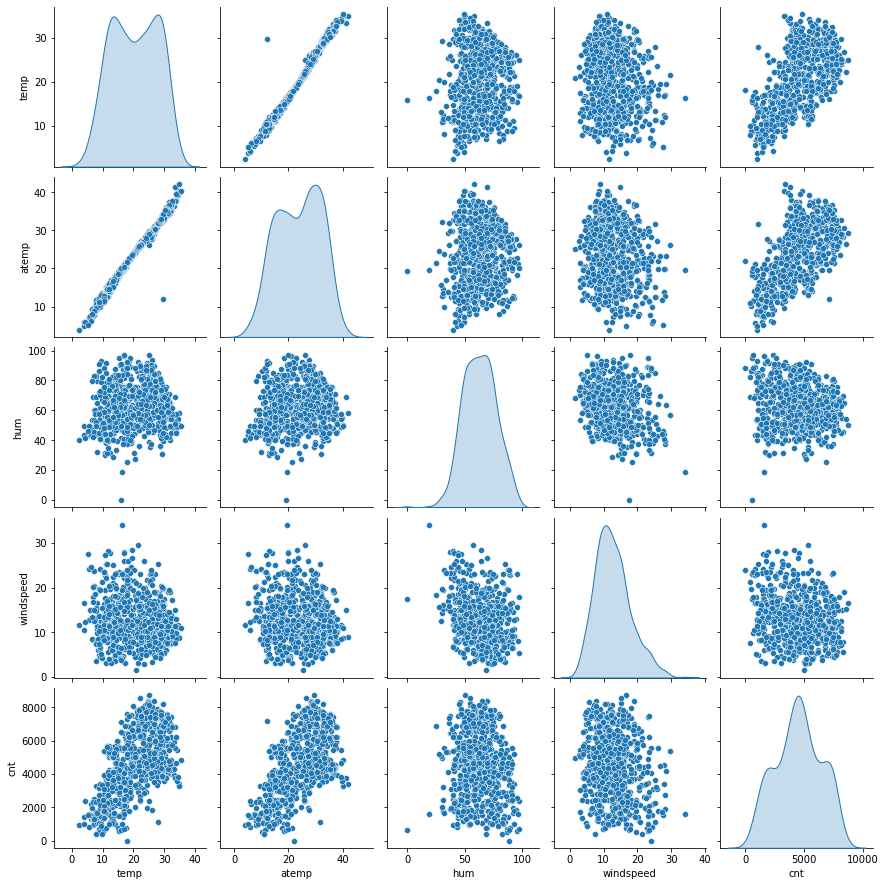

In [6]:
sns.pairplot(df_org[[ 'temp', 'atemp', 'hum', 'windspeed','cnt']], diag_kind='kde');
plt.show()

### Insights : There is linear relation between temperature and Target variable(Count)

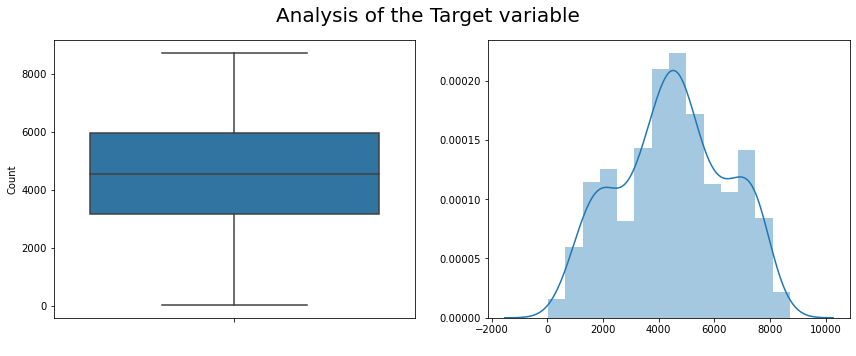

In [7]:
fig, ax= plt.subplots(nrows= 1, ncols= 2, figsize= (12, 5))

fig.suptitle('Analysis of the Target variable', fontsize= 20)

# Plot 1
sns.boxplot(y=df['cnt'], ax= ax[0])
ax[0].set_ylabel('Count')
ax[0].set_xlabel(' ')

# Plot 2
sns.distplot(df['cnt'], ax= ax[1])
ax[1].set_ylabel(' ')
ax[1].set_xlabel(' ')

plt.tight_layout()
plt.show()

### Insights : Target variable is normally distributed with median value of around 4400.

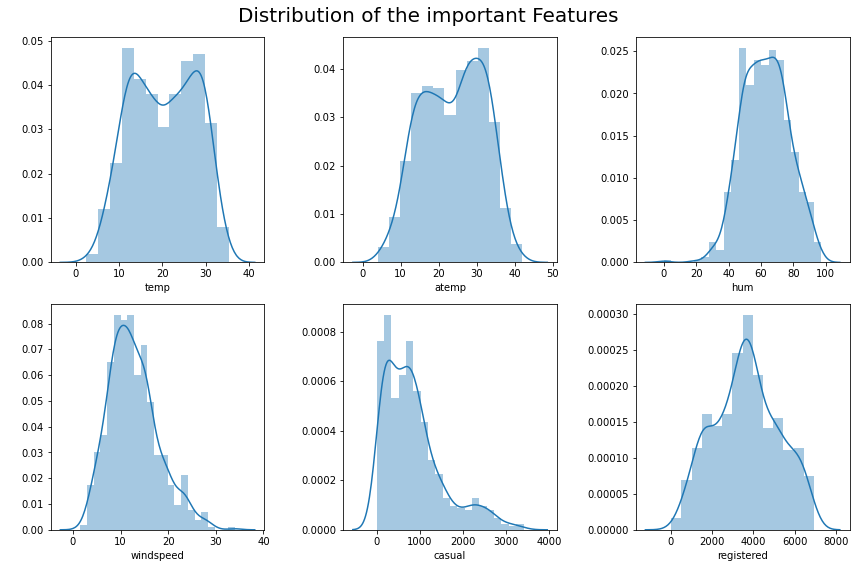

In [8]:
var_r = 0
var_c = 0
var_cnt = 0

fig, ax= plt.subplots(nrows= 2, ncols= 3, figsize= (12, 8))
fig.suptitle('Distribution of the important Features', fontsize= 20)

for i in ['temp', 'atemp', 'hum', 'windspeed', 'casual','registered']:
    sns.distplot(df[i], ax= ax[var_r][var_c])
    ax[var_r][var_c].set_ylabel(' ')
    ax[var_r][var_c].set_xlabel(i)

    var_cnt +=1
    if var_cnt %3 ==0:
        var_r +=1
        var_c = 0
    else:
        var_c +=1
        
plt.tight_layout()
plt.show()

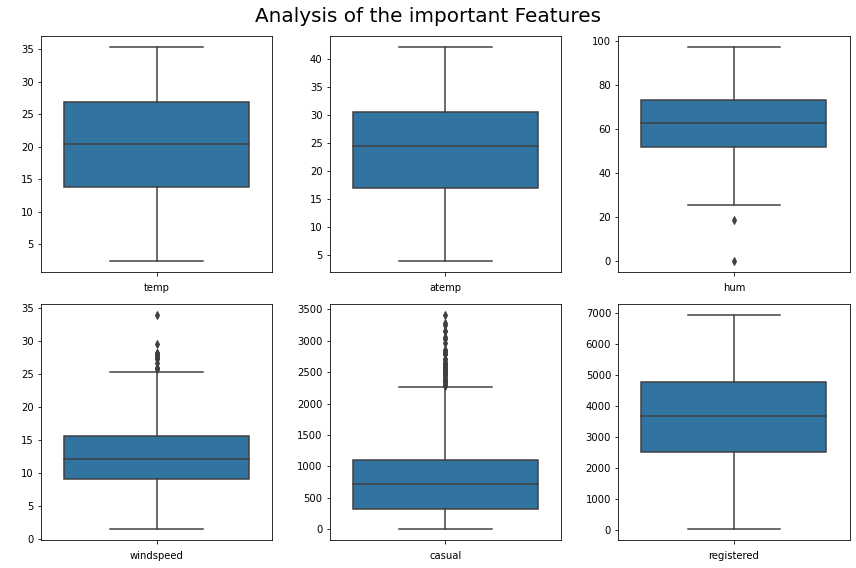

In [9]:
var_r = 0
var_c = 0
var_cnt = 0

fig, ax= plt.subplots(nrows= 2, ncols= 3, figsize= (12, 8))
fig.suptitle('Analysis of the important Features', fontsize= 20)

for i in ['temp', 'atemp', 'hum', 'windspeed', 'casual','registered']:
    sns.boxplot(y=df[i], ax= ax[var_r][var_c])
    ax[var_r][var_c].set_ylabel(' ')
    ax[var_r][var_c].set_xlabel(i)

    var_cnt +=1
    if var_cnt %3 ==0:
        var_r +=1
        var_c = 0
    else:
        var_c +=1
        
plt.tight_layout()
plt.show()

### Insights: People prefer bikes when temperture is moderate and humidity is high.

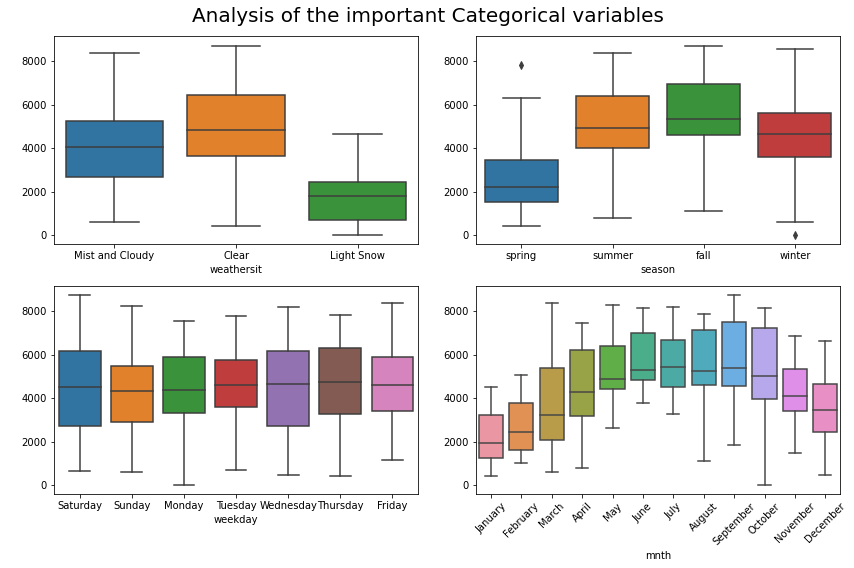

In [10]:
var_r = 0
var_c = 0
var_cnt = 0

fig, ax= plt.subplots(nrows= 2, ncols= 2, figsize= (12, 8))
fig.suptitle('Analysis of the important Categorical variables', fontsize= 20)

for i in ['weathersit', 'season', 'weekday','mnth', ]:
    sns.boxplot(data=df, x=i, y="cnt", ax= ax[var_r][var_c])
    ax[var_r][var_c].set_ylabel(' ')
    ax[var_r][var_c].set_xlabel(i)
    plt.xticks(rotation=45)
    var_cnt +=1
    if var_cnt %2 ==0:
        var_r +=1
        var_c = 0
    else:
        var_c +=1
        
plt.tight_layout()
plt.show()

### Insights :
>### Weather: Almost 67% of the bike booking were happening during clear weather with a median of around 4900.
>### Season: Fall and Summer seasons have a median of more than 5000 which indicates that weather shows some trend in bike booking.
>### Weekday: All weekday shows a similar trend which indicates that they have minor influence on prediction
>### Month: From May to October have a higher booking which indicates that it can be a good indicator for prediction.

<html>
<body>
    <h1 style="color: red">Model Selection</h1>
</body>
</html>

<font color = blue >

>### From above EDA, we know now that Target variable is dependent on multiple features and from pair plot we come to know that there is linear realtion between Target and Temperature. Hence we are selecting linear regression model for this analysis.

</font>

<html>
<body>
    <h1 style="color: red">Multiple linear regression</h1>
</body>
</html>

>### Droping below two variable to avoid multicollinearity as sum of casual and registered is equal to the target variable 

In [11]:
df.drop(['casual', 'registered'],axis=1,inplace=True)

### Creating Dummy Variables

In [12]:
df_season = pd.get_dummies(df.season,drop_first=True)
df_mnth = pd.get_dummies(df.mnth,drop_first=True)
df_weekday = pd.get_dummies(df.weekday,drop_first=True)
df_weathersit = pd.get_dummies(df.weathersit,drop_first=True)
df = pd.concat([df,df_weathersit,df_season,df_mnth,df_weekday],axis=1)
df.drop(['season','mnth','weekday','weathersit'],axis=1,inplace=True,)
df.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,Light Snow,Mist and Cloudy,...,May,November,October,September,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,0,1,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,0,1,...,0,0,0,0,0,0,1,0,0,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,0,0,...,0,0,0,0,0,0,0,0,0,1


### Train Test split

In [13]:
df_train, df_test = train_test_split(df,train_size=0.7,random_state=41) 

### Rescaling of Data

In [14]:
scalar = MinMaxScaler()
num_var = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']
df_train[num_var] = scalar.fit_transform(df_train[num_var])
df_test[num_var] = scalar.transform(df_test[num_var])

### Spliting data into X and y

In [15]:
y_train = df_train.pop("cnt")
X_train = df_train
y_test = df_test.pop("cnt")
X_test = df_test


In [16]:
df_train.shape

(510, 29)

### Model Development

In [17]:
X_train_sm = sm.add_constant(X_train)
lr = sm.OLS(y_train, X_train_sm)
lr_model = lr.fit()
lr_model.summary()
print(lr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     97.79
Date:                Tue, 13 Dec 2022   Prob (F-statistic):          7.15e-179
Time:                        19:23:56   Log-Likelihood:                 531.64
No. Observations:                 510   AIC:                            -1005.
Df Residuals:                     481   BIC:                            -882.5
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3096      0.035     

### VIF

In [18]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,workingday,85.22
3,temp,66.04
4,atemp,55.57
24,Saturday,20.74
25,Sunday,19.88
9,spring,9.82
10,summer,7.88
11,winter,7.47
16,July,5.85
1,holiday,5.82


### Performance Improvement

>### Below Features are dropped one by one in below sequence
>>### High P-value and low VIF
>>### High VIF and low p-value



In [19]:
X_train.drop(["March"], axis = 1, inplace=True)
X_train.drop(["October"], axis = 1, inplace=True)
X_train.drop(["June"], axis = 1, inplace=True)
X_train.drop(["Wednesday"], axis = 1, inplace=True)
X_train.drop(["atemp"], axis = 1, inplace=True)
X_train.drop(["holiday"], axis = 1, inplace=True)
X_train.drop(["Thursday","August"], axis = 1, inplace=True)
X_train.drop(["Tuesday","May"], axis = 1, inplace=True)
X_train.drop(["Monday"], axis = 1, inplace=True)
X_train.drop(["February"], axis = 1, inplace=True)
X_train.drop(["Sunday"], axis = 1, inplace=True)
X_train.drop(["November","December","January"], axis = 1, inplace=True)
X_train.drop(["hum"], axis = 1, inplace=True)
X_train.drop(["July"], axis = 1, inplace=True)
X_train.drop(["spring"], axis = 1, inplace=True)
X_test = X_test[X_train.columns]

In [20]:
X_train_sm = sm.add_constant(X_train)
lr = sm.OLS(y_train, X_train_sm)
lr_model = lr.fit()
lr_model.summary()
print(lr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     229.4
Date:                Tue, 13 Dec 2022   Prob (F-statistic):          1.84e-179
Time:                        19:23:56   Log-Likelihood:                 486.06
No. Observations:                 510   AIC:                            -950.1
Df Residuals:                     499   BIC:                            -903.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0824      0.019     

In [21]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,temp,4.76
3,windspeed,4.12
1,workingday,3.81
0,yr,1.84
9,Saturday,1.72
6,summer,1.62
5,Mist and Cloudy,1.52
7,winter,1.35
8,September,1.21
4,Light Snow,1.08


In [22]:
results_summary = lr_model.summary()
results_as_html = results_summary.tables[1].as_html()
df_result = pd.DataFrame(pd.read_html(results_as_html, header=0, index_col=0)[0])
print(pd.DataFrame(df_result.sort_values(by='coef',ascending=False)))
df_result = df_result.sort_values(by='coef',ascending=False)

                   coef  std err       t  P>|t|  [0.025  0.975]
temp             0.5502    0.020  27.845  0.000   0.511   0.589
yr               0.2365    0.008  28.145  0.000   0.220   0.253
winter           0.1319    0.011  12.095  0.000   0.110   0.153
summer           0.0869    0.010   8.478  0.000   0.067   0.107
const            0.0824    0.019   4.268  0.000   0.044   0.120
September        0.0737    0.016   4.603  0.000   0.042   0.105
Saturday         0.0471    0.014   3.274  0.001   0.019   0.075
workingday       0.0422    0.011   3.825  0.000   0.021   0.064
Mist and Cloudy -0.0733    0.009  -8.165  0.000  -0.091  -0.056
windspeed       -0.1081    0.023  -4.782  0.000  -0.152  -0.064
Light Snow      -0.2848    0.028 -10.052  0.000  -0.341  -0.229


In [23]:
X_test_sm = sm.add_constant(X_test)

y_test_pred = lr_model.predict(X_test_sm)

### Final R2 Score

In [24]:
r2_score(y_true=y_test,y_pred=y_test_pred)

0.8262371440687304

<html>
<body>
    <h2 style="color: blue">   Train and Test R2 Score is 82.6%</h2>
</body>
</html>

   


### Residual Analysis

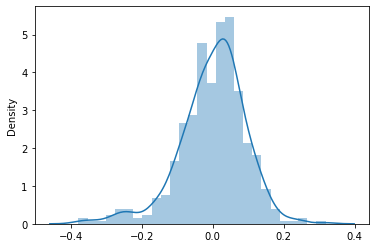

In [25]:
X_test_sm = sm.add_constant(X_test)
y_train_pred = lr_model.predict(X_train_sm)
res = y_train - y_train_pred
sns.distplot(res);

### Mean Absolute Error Percentage

In [26]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_test,y_test_pred)*100

18.157628487032078

### Prediction Accuracy Plot

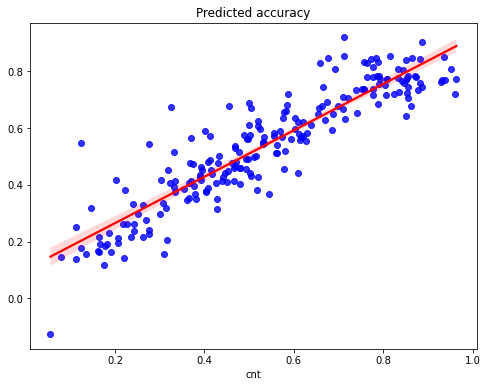

In [27]:
fig = plt.figure(figsize=(8,6))
sns.regplot(y_test,y_test_pred,scatter_kws = {'color':'blue'},line_kws = {'color':'red'});
plt.title('Predicted accuracy')
plt.show();

### Q-Q Plot

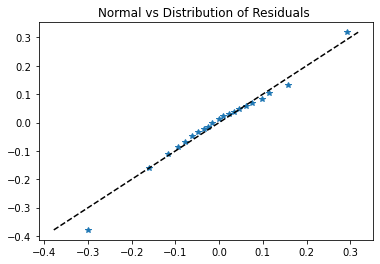

In [28]:
m = (y_train-y_train_pred).mean()
s = (y_train-y_train_pred).std()

ref_normal = np.random.normal(m,s,(y_train-y_train_pred).shape[0])


percent = np.linspace(0,100,21)
ref_normal = np.percentile(ref_normal, percent)
residual = np.percentile(y_train - y_train_pred , percent)

plt.plot(ref_normal,residual, ls="", marker="*")

x = np.linspace(np.min((ref_normal.min(),residual.min())), np.max((ref_normal.max(),residual.max())))
plt.plot(x,x, color="k", ls="--")
plt.title('Normal vs Distribution of Residuals ')
plt.show()

### Final Equation

In [29]:
def final_eq():    
    final_eq = ' '
    for i in df_result.index:
        if i == 'const':
            final_eq = '(' + str(df_result.coef[i]) +') + ' + final_eq
        else:
            final_eq += i + ' * (' + str(df_result.coef[i]) +')'
        final_eq += ' + '

    print("Final Equation :",final_eq)
final_eq()

Final Equation : (0.0824) +  temp * (0.5502) + yr * (0.2365) + winter * (0.1319) + summer * (0.0869) +  + September * (0.0737) + Saturday * (0.0471) + workingday * (0.0422) + Mist and Cloudy * (-0.0733) + windspeed * (-0.1081) + Light Snow * (-0.2848) + 


<font color = red >

# Buisness Recomadation

</font>


<font color = green >


>### Temperature: Most important factor affecting demand is temperature. With a coefficient of 0.5502, for every change in temperature of 1 degrees, demand increases by a factor of 0.5502 (temperature x 0.5502). Based on this, company will have to consider:Necessary capacity building during hotter months to fulfil the demand

    
>### Light snow: Second most important factor is Light Rain or Snow with a coefficient of (-0.2848) Hence, if a particular day has light rains, it is expected to reduce the demand by 28.48%. Based on this, itis recommended to develop a sentiment based advertisement plan that heavily promotes fun element of the riding bikes in rain.

>### Year: Third most important factor is year with a coefficient value of 0.2365. Based on the historical data, given all internal and external factors remain unchanged, the company is expected to see annual growth over last year at around 23.65%.This helps us in factoring teh revenue and cost projections over a period of time.

>### Winter: Fourth most important factor is winter with a coefficient of 0.1319. Tihs signifies that every winter, the demand is expecteed to incerase by a factor of 0.1319 basd on other months.From the available data, Winter season constitutes of Sep, Oct, Nov and December months.Company needs to work on capacity planing of these months and additionally plan for promotional campaigns in case a competitors exist with similar value propositions
